In [1]:
import time
import pandas as pd

from gurobipy import *
from functions import *

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
# parametros
instances = ['instancia1']#, 'instancia2','instancia3']#
Qs = [565]#, 565, 565]#
num_periodos = [0]#

In [3]:
start_time_exp = time.time()
for instance in instances:
    
    path_dem = '/home/wilmer/Documentos/Codes/tesis/Instancias/'+instance+'/demanda.csv'
    path_preco = '/home/wilmer/Documentos/Codes/tesis/Instancias/'+instance+'/preco.csv'
    path_rota = '/home/wilmer/Documentos/Codes/tesis/Instancias/'+instance+'/rota.csv'
    
    Q = Qs[instances.index(instance)]

    # chamar dados
    demanda, preco_, rota1 = read_data(path_dem, path_preco, path_rota)

    for num_periodo in num_periodos:
        # Criar Conjuntos
        I, I2, J, OD, NAD, V,  T, stations, VK, P, d, dd, n, BR, index, indexCombiDem, indexCombiDem0, demandaFil= create_sets(demanda, preco_, rota1, num_periodo)

        # criar modelo
        start_time = time.time()
        model, A, X, Y, BNA = create_model(I, I2, VK, NAD, BR, P, Q, d, index, indexCombiDem, indexCombiDem0, demandaFil, dd)
        end_time = time.time()
        tempo = end_time - start_time

        # # Redirigir la salida estándar a un archivo
        # old_stdout = sys.stdout
        # new_stdout = io.StringIO()
        # sys.stdout = new_stdout

        # # Optimizar o modelo
        # model.optimize()

        # Salvar solucao
        a = save_solution(model, BR, P, d, X, Y, BNA, num_periodo, instance, indexCombiDem)
        # print('Tempo para criar o modelo: ', tempo)

        # # Volver a la salida estándar
        # sys.stdout = old_stdout

        # # Obtener la salida de la optimización
        # output = new_stdout.getvalue()

        # # Guardar la salida en un archivo de texto
        # with open('C:/Users/LAB_C/Documents/wilmer/tesis/ResultadosNew/RestrSemDemanComp/modelo1_'+instance+'_t'+str(num_periodo)+'.txt', 'w') as f:
        #     f.write(output)

end_time_exp = time.time()
all_time = end_time_exp - start_time_exp

print("FO: ", model.ObjVal)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-25
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 24.04.1 LTS")

CPU model: AMD Ryzen 5 2500U with Radeon Vega Mobile Gfx, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 183 rows, 77 columns and 399 nonzeros
Model fingerprint: 0x8bc4eb61
Variable types: 0 continuous, 77 integer (11 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [6e+01, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 6e+02]
Found heuristic solution: objective -0.0000000
Presolve removed 118 rows and 31 columns
Presolve time: 0.00s
Presolved: 65 rows, 46 columns, 181 nonzeros
Variable types: 0 continuous, 46 integer (3 binary)

Root relaxation: objective 1.253529e+06, 27 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds     

In [11]:
a.columns

Index(['o-d', 'Origen', 'Destino', 'Vagon', 'classe', 'Periodo', 'Preco',
       'Demanda', 'Assignments', 'Authorizations', 'Binaria'],
      dtype='object')

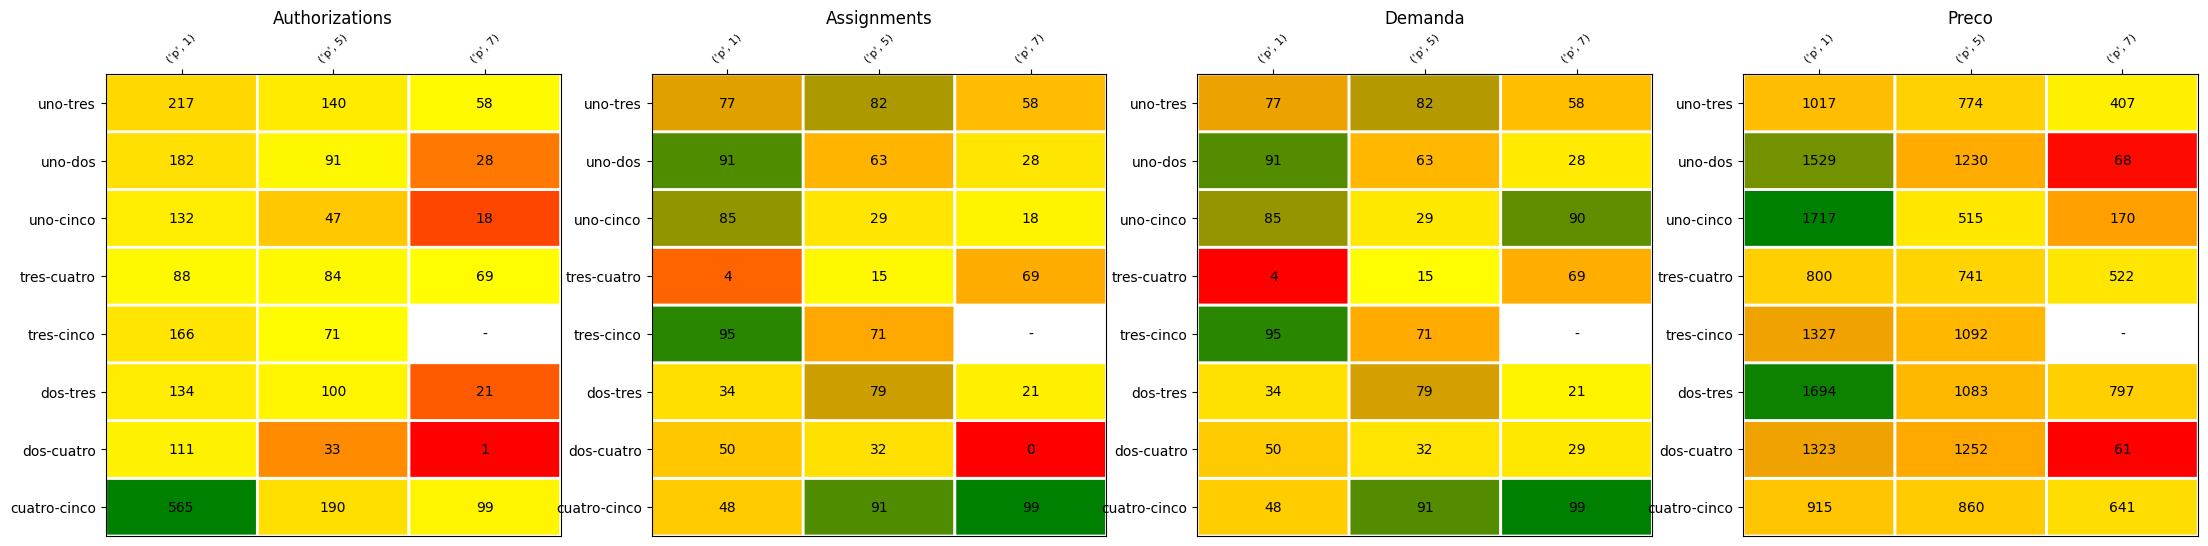

In [14]:
attrs = ['Authorizations','Assignments','Demanda','Preco']
# attrs = ['Authorizations','Demanda']

grafica(a,attrs, 6, 27, 4)

In [5]:
# # chamar dados
# demanda, preco_, rota1 = read_data(path_dem, path_preco, path_rota)

# # Criar Conjuntos
# I, I2, J, OD, NAD, V,  T, stations, VK, P, d, n, BR, rota, index0, index = crate_sets(demanda, preco_, rota1, num_periodo)

# # criar modelo
# model, A, X, Y, BNA = create_model(I, I2, J, V, VK, T, OD, NAD, BR, P, Q, d, index0, index, rota)

# # Redirigir la salida estándar a un archivo
# old_stdout = sys.stdout
# new_stdout = io.StringIO()
# sys.stdout = new_stdout

# # Optimizar o modelo
# model.optimize()

# # Salcar solucao
# save_solution(model, OD, V, VK, T, BR, P, d, X, Y, BNA, num_periodo)

# # Volver a la salida estándar
# sys.stdout = old_stdout

# # Obtener la salida de la optimización
# output = new_stdout.getvalue()

# # Guardar la salida en un archivo de texto
# with open('modelo1_',instance+'_t'+str(num_periodo)+'.txt', 'w') as f:
#     f.write(output)

In [6]:
# import random 
# rota1 = ['uno','dos','tres', 'cuatro', 'cinco']
# rota = [0] + rota1

# OD = [('uno','dos'),
#            ('uno','tres'),
#            ('uno','cuatro'),
#            ('uno','cinco'),
#            ('dos','tres'),
#            ('dos','cuatro'),
#            ('dos','cinco'),
#            ('tres','cuatro'),
#            ('tres','cinco'),
#            ('cuatro','cinco'),]

# AD = [(i,j) for i,j in OD if rota1.index(j) == rota1.index(i)+1]
# NAD = [(i,j) for i,j in OD if rota1.index(j) != rota1.index(i)+1]

# I = ['uno','dos','tres', 'cuatro']
# I2 = [0] + I

# J = ['dos','tres','cuatro', 'cinco']
# V = ['p','z']
# T = [0,1]
# Q = 700 
# n = len(rota) - 1 
# VK = {'p':[1,5,7],'z':[1,3,7]}

# d = {(i,j,v,k,t): np.random.randint(1,100) for i,j in OD for v in V for k in VK[v] for t in T }

# P = {}
# for i,j in OD:
#     for v in V:
#         aleat = sorted(random.sample(range(50, 2000 + 1), len(VK[v])), reverse=True)
#         for k,valor in enumerate(aleat):
#             P[(i,j,v,VK[v][k])] = valor

# # corrigir instancias
# d = {(i,j,v,k,t): d[(i,j,v,k,t)] if (i,j,v,k,t) in d else 0  for i,j in OD for v in V for k in VK[v] for t in T}
# P = {(i,j,v,k): P[(i,j,v,k)] if (i,j,v,k) in P else 0  for i,j in OD for v in V for k in VK[v] }